In [11]:
import pandas as pd
import numpy as np
base = 'd:/multiLabel/clothes'

DATA_PATH = base
train_df = pd.read_csv(DATA_PATH + '/train.csv')
val_df = pd.read_csv(DATA_PATH + '/val.csv')
test_df = pd.read_csv(DATA_PATH + '/test.csv')

print(train_df.head())

   Unnamed: 0                                              image  black  blue  \
0           0  ./clothes_dataset\blue_shorts\256d854b55ac32ea...    0.0   1.0   
1           1  ./clothes_dataset\red_pants\584f778aece14f07c2...    0.0   0.0   
2           2  ./clothes_dataset\green_pants\ec543ca241cefb2b...    0.0   0.0   
3           3  ./clothes_dataset\brown_shorts\c8db9e0f7010592...    0.0   0.0   
4           4  ./clothes_dataset\white_dress\551373c80717c5b0...    0.0   0.0   

   brown  green  red  white  dress  shirt  pants  shorts  shoes  
0    0.0    0.0  0.0    0.0    0.0    0.0    0.0     1.0    0.0  
1    0.0    0.0  1.0    0.0    0.0    0.0    1.0     0.0    0.0  
2    0.0    1.0  0.0    0.0    0.0    0.0    1.0     0.0    0.0  
3    1.0    0.0  0.0    0.0    0.0    0.0    0.0     1.0    0.0  
4    0.0    0.0  0.0    1.0    1.0    0.0    0.0     0.0    0.0  


## Image Generator

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# 이미지 제너레이터를 정의합니다.
train_datagen = ImageDataGenerator(rescale=1. / 255)
val_datagen = ImageDataGenerator(rescale=1. / 255)

def get_steps(num_samples, batch_size):
    if (num_samples % batch_size) > 0:
        return (num_samples // batch_size) + 1
    else:
        return num_samples // batch_size

## Building a model

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

model = Sequential()
# 입력 데이터의 형태를 꼭 명시해야 합니다.
model.add(Flatten(input_shape = (112, 112, 3))) # (112, 112, 3) -> (112 * 112 * 3)
model.add(Dense(128, activation = 'relu')) # 128개의 출력을 가지는 Dense 층
model.add(Dense(64, activation = 'relu')) # 64개의 출력을 가지는 Dense 층
model.add(Dense(11, activation = 'sigmoid')) # 11개의 출력을 가지는 신경망

model.compile(optimizer = 'adam', 
            loss = 'binary_crossentropy', 
            metrics = ['acc'])

In [12]:
train_df.head()

,Unnamed: 0,image,black,blue,brown,green,red,white,dress,shirt,pants,shorts,shoes
0,0,./clothes_dataset\blue_shorts\256d854b55ac32ea...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,./clothes_dataset\red_pants\584f778aece14f07c2...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2,./clothes_dataset\green_pants\ec543ca241cefb2b...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,3,./clothes_dataset\brown_shorts\c8db9e0f7010592...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,4,./clothes_dataset\white_dress\551373c80717c5b0...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [24]:
# Make Generator

batch_size = 32
class_col = train_df.columns[2:]

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=base,         #d:/multiLabel/clothes
    x_col = 'image',        # train_df['image']
    y_col = class_col,      # traind_df[['black','blue','brown',...,'shoes']]
    target_size = (112, 112),
    color_mode='rgb',
    class_mode='raw',
    batch_size=batch_size,
    seed=42
)

Found 5578 validated image filenames.


Index(['white', 'shoes'], dtype='object')


c:\Users\user\miniconda3\envs\gpu\lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


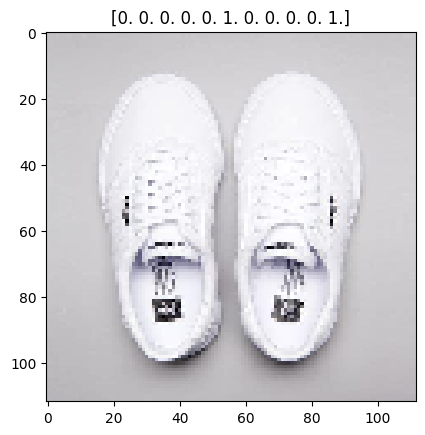

In [43]:
len(train_generator)  #5578 / 32(batch_size)
# 훈련자료: w,b를 갱신
import matplotlib.pyplot as plt
plt.imshow(train_generator[0][0][0])
plt.title(train_generator[0][1][0])
#[0 0 0 0 0 1 0 0 0 0 1] == white / shoes
for x in np.where(train_generator[0][1][0] ==1):
    print(class_col[x])

In [48]:
# model.fit할 때 훈련자료에서 갱신 된 w,b가 적합한지를 검증하는 자료
# 보통 테스트데이터로 validate를 함, 하지만 여기선 validation 별도로 갖고 있음
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=base,
    x_col = 'image',
    y_col = class_col,
    target_size = (112, 112),
    color_mode='rgb',
    class_mode='raw',
    batch_size=batch_size,
    shuffle=True
)

Found 2391 validated image filenames.


## Modeling

In [50]:
model.fit(train_generator,
            steps_per_epoch=get_steps(len(train_df), batch_size),
            validation_data = val_generator,
            validation_steps=get_steps(len(val_df), batch_size),
            epochs = 1)

175/175 [==============================] - 37s 215ms/step - loss: 0.3050 - acc: 0.3663 - val_loss: 0.2859 - val_acc: 0.3685


In [51]:
# 모델 평가
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=base,
    x_col='image',
    y_col=class_col,
    target_size=(112, 112),
    color_mode='rgb',
    class_mode='raw',
    batch_size=batch_size,
    shuffle=True
)

loss_and_metrics = model.evaluate(test_generator,
                                steps=get_steps(len(test_df), batch_size))
print('loss_and_metrics : ' + str(loss_and_metrics)) 

# loss_and_metrics : [0.18328142291474564, 0.9285179]

Found 3416 validated image filenames.
107/107 [==============================] - 45s 427ms/step - loss: 0.2809 - acc: 0.3451
loss_and_metrics : [0.28088659048080444, 0.3451405167579651]


## Save the model

In [52]:
import os
save_path = os.path.join('model', 'img_generator_model.h5')
model.save(save_path)

## Visualize the prediction

In [54]:
## 예측 추가
preds = model.predict(test_generator)
preds

array([[1.61810100e-01, 2.00242892e-01, 4.65091411e-03, ...,
        2.45263632e-02, 1.92458567e-03, 8.06864977e-01],
       [4.12290655e-02, 9.31508660e-01, 1.97502275e-04, ...,
        9.89926696e-01, 3.02041303e-02, 8.88452632e-05],
       [2.84182876e-01, 2.36345202e-01, 4.39688228e-02, ...,
        7.88014472e-01, 2.87358433e-01, 3.69700104e-01],
       ...,
       [7.84790754e-01, 2.33296096e-01, 2.14637648e-02, ...,
        7.05076084e-02, 1.38216943e-01, 3.81201021e-02],
       [5.25253303e-02, 3.18846703e-02, 4.42122528e-03, ...,
        8.19295272e-02, 1.01196496e-02, 3.78001004e-01],
       [1.65766239e-01, 1.26012135e-02, 1.29532805e-02, ...,
        2.18080193e-01, 7.57948612e-07, 2.28171125e-02]], dtype=float32)

In [58]:
preds[0]

array([0.1618101 , 0.20024289, 0.00465091, 0.40267769, 0.00925261,
       0.05755666, 0.00153961, 0.2184177 , 0.02452636, 0.00192459,
       0.806865  ], dtype=float32)

In [57]:
np.argmax(preds[0])

10

In [ ]:
class_col[np.where([preds[0]==0.806865])]

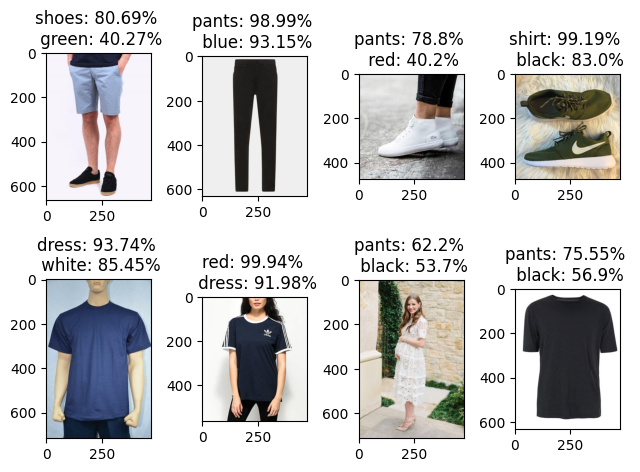

In [60]:
# 8개만 예측해보도록 하겠습니다.
do_preds = preds[:8]

import cv2
for i, pred in enumerate(do_preds):
    plt.subplot(2, 4, i + 1)
    prob = zip(class_col, list(pred))
    # item --> prob
    # contributor: '뱅커'님
    prob = sorted(list(prob), key = lambda z: z[1], reverse = True)[:2]

    image = cv2.imread(base + test_df['image'][i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.imshow(image)
    plt.title(f'{prob[0][0]}: {round(prob[0][1] * 100, 2)}% \n {prob[1][0]}: {round(prob[1][1] * 100, 2)}%')

plt.tight_layout()

## 만약 하나의 자료로만 예측한다면?

black
pants


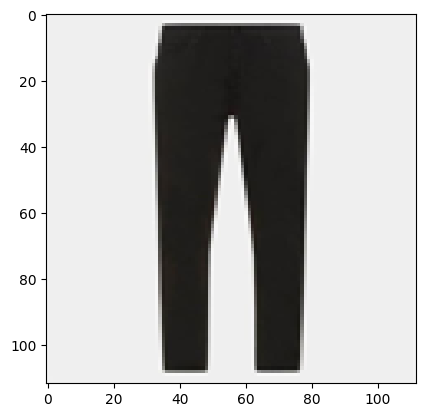

In [61]:
## 새로운 데이터로 해야하지만
# 테스트자료 한개 꺼내서 에측하고자함


import numpy as np
from PIL import Image
base='D:/multiLabel/clothes/'
file=base+'./clothes_dataset/black_pants/0f8eb4509cea01f9656e8b31e3af0d29852cd90e.jpg'   
img=Image.open(file).resize((112,112))
img=np.array(img)

plt.imshow(img)
x_test=img.reshape(1, 112,112,3)
yhat = model.predict(x_test)

for x in np.where(yhat[0]==1)[0]:
    print(class_col[x])